# Import Libraries

In [19]:
import pandas as pd
import numpy as np
import requests
from datetime import date, datetime
import json
import io
import zipfile
import re
# Matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, PercentFormatter, FuncFormatter
import seaborn as sns
# Set Seaborn properties
sns.set()
plt.style.use('fivethirtyeight')

# Necessary to suppress pandas plotting error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Create CFTC Class and Functions

In [20]:
class CFTC:

    def __init__(self):
        self.headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}
        # self.cot = self.get_cftc_cot()
        self.reportable_positions = [
            'Dealer_Positions_Long_All', 'Dealer_Positions_Short_All', 
            'Dealer_Positions_Spread_All', 'Asset_Mgr_Positions_Long_All', 
            'Asset_Mgr_Positions_Short_All', 'Asset_Mgr_Positions_Spread_All', 
            'Lev_Money_Positions_Long_All', 'Lev_Money_Positions_Short_All', 
            'Lev_Money_Positions_Spread_All', 'Other_Rept_Positions_Long_All', 
            'Other_Rept_Positions_Short_All', 'Other_Rept_Positions_Spread_All',
            'Traders_Tot_Rept_Long_All', 'Traders_Tot_Rept_Short_All'
            ]
        self.nonreportable_positions = [
            'NonRept_Positions_Long_All', 'NonRept_Positions_Short_All'
            ]
        self.short_list = "(" + ")|(".join(["Short", "Spread"]) + ")"
        self.long_list = "(" + ")|(".join(["Long", "Spread"]) + ")"
        self.trader_types = ['Lev_Money', 'Other_Rept', 'Asset_Mgr', 'Dealer', 'Traders']

    def get_cftc_cot(self):
        # Create blank dataframe    
        df = pd.DataFrame()
        # Get CFTC data
        for i in range(2017,datetime.today().year+1):  #BTC futures first offered on 12/17/2017            
            # Get financial futures and options reports from CFTC
            response = requests.get('https://www.cftc.gov/files/dea/history/com_fin_xls_'+str(i)+'.zip', stream=True, headers=self.headers)
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall()
            _ = pd.read_excel(z.namelist()[0])
            df = pd.concat([df, _])

        df = df[df['CFTC_Contract_Market_Code'] == '133741']
        df = df.sort_values('Report_Date_as_MM_DD_YYYY')
        df = df.set_index('Report_Date_as_MM_DD_YYYY', drop=True)
        return df

    def create_dataframes(self, df):
        # Create dataframe of reportable and non-reportable positions positions
        reportable = df.loc[:, df.columns.isin(self.reportable_positions)]
        non_reportable = df.loc[:, df.columns.isin(self.nonreportable_positions)]
        # Temp dataframes
        rl = df.loc[:, df.columns.isin([x for x in self.reportable_positions if re.search(self.long_list, x)])]
        rs = df.loc[:, df.columns.isin([x for x in self.reportable_positions if re.search(self.short_list, x)])]
        # Create dataframes of longs and shorts for reportable positions
        reportable_long = pd.DataFrame(index=rl.index)
        reportable_short = pd.DataFrame(index=rs.index)
        for types in self.trader_types:
            reportable_long[types] = rl.loc[:,[col for col in rl.columns if types in col]].sum(axis=1)
            reportable_short[types] = rs.loc[:,[col for col in rs.columns if types in col]].sum(axis=1) * -1
        # Create dataframes of sums of all trader types
        reportable_long_total = reportable_long.sum(axis=1)
        reportable_short_total = reportable_short.sum(axis=1)
        # Create dataframes of longs and shorts for reportable and non-reportable positions
        all_longs = pd.concat([reportable_long_total, non_reportable['NonRept_Positions_Long_All']], axis=1)
        all_longs.columns = ['Rept_Positions_Long_All', 'NonRept_Positions_Long_All']
        all_shorts = pd.concat([reportable_short_total, non_reportable['NonRept_Positions_Short_All']*-1], axis=1)
        all_shorts.columns = ['Rept_Positions_Short_All', 'NonRept_Positions_Short_All']
        # Create dataframe of net position
        reportable_net = pd.concat([reportable_long_total, reportable_short_total], axis=1)
        reportable_net = reportable_net.sum(axis=1)
        return reportable_long, reportable_short, all_longs, all_shorts

    def plot_reportable_positions(self, long_df, short_df, width=25, height=12, ratio_line=True):
        fig, ax1 = plt.subplots(figsize=(width,height))
        ax2 = ax1.twinx()
        # Stackplots of long and short positions by trader type
        ax1.stackplot(long_df.index, [long_df[types] for types in self.trader_types], colors=plt.cm.Set1.colors, alpha=0.5, labels=self.trader_types)
        ax1.stackplot(short_df.index, [short_df[types] for types in self.trader_types], colors=plt.cm.Set1.colors, alpha=0.5)
        ax1.set_ylabel('<--- Shorts   Longs --->')
        ax1.set_ylim([-8000,8000])
        yticks = ax1.get_yticks()
        ax1.set_yticklabels([int(abs(tick)) for tick in yticks]) 
        if ratio_line:
            ax2.plot(short_df.sum(axis=1)/long_df.sum(axis=1)*-1, color='black', label='Short-to-Long Ratio', linestyle=":")
            ax2.set_ylim([0, 2])
            ax2.set_ylabel('Ratio of Shorts-to-Longs')
            ax2.legend()
        ax2.grid(b=None)
        ax1.legend(loc=2)
        ax1.margins(x=.0, y=0, tight=True)
        plt.title('CME Bitcoin Futures - Longs and Shorts by Trader Type - Reportable Positions')
        ax1.axhline(y=0, linewidth=0.5, color='black', linestyle='-', alpha=0.8)
        plt.show()

    def plot_longs_vs_shorts(self, all_longs, all_shorts, width=25, height=12):
        fig, ax1 = plt.subplots(figsize=(width,height))
        ax1.stackplot(all_longs.index, [all_longs['Rept_Positions_Long_All'], all_longs['NonRept_Positions_Long_All']], colors=plt.cm.Set1.colors, alpha=0.5, labels=['Reportable Positions', 'Non-Reportable Positions'])
        ax1.stackplot(all_shorts.index, [all_shorts['Rept_Positions_Short_All'], all_shorts['NonRept_Positions_Short_All']], colors=plt.cm.Set1.colors, alpha=0.5)
        ax1.set_ylabel('<--- Shorts   Longs --->')
        ax1.set_ylim([-8000,8000])
        yticks = ax1.get_yticks()
        ax1.set_yticklabels([int(abs(tick)) for tick in yticks])
        ax1.legend(loc=2)
        ax1.margins(x=.0, y=0, tight=True)
        plt.title('CME Bitcoin Futures - Longs and Shorts - Reportable vs Non-Reportable Positions')
        ax1.axhline(y=0, linewidth=0.5, color='black', linestyle='-')
        plt.show()

    def plot_open_interest(self, df, width=20, height=10):
        fig, ax1 = plt.subplots(figsize=(width,height))
        ax1.bar(self.cot.index, self.cot['Open_Interest_All'], label='Weekly Open Interest', width=4)
        ax1.set_ylabel('Open Interest')
        ax1.margins(x=0, y=0, tight=True)
        plt.title('CME Bitcoin Futures - Weekly Open Interest')
        plt.show()

# Instantiate CFTC Class

In [21]:
cftc = CFTC()
cftc.cot = cftc.get_cftc_cot()
cftc.reportable_long, cftc.reportable_short, cftc.all_longs, cftc.all_shorts = cftc.create_dataframes(cftc.cot)

# Plot Total Weekly Open Interest

This plot shows the weekly open interest for all positions for CFTC Bitoin futures.

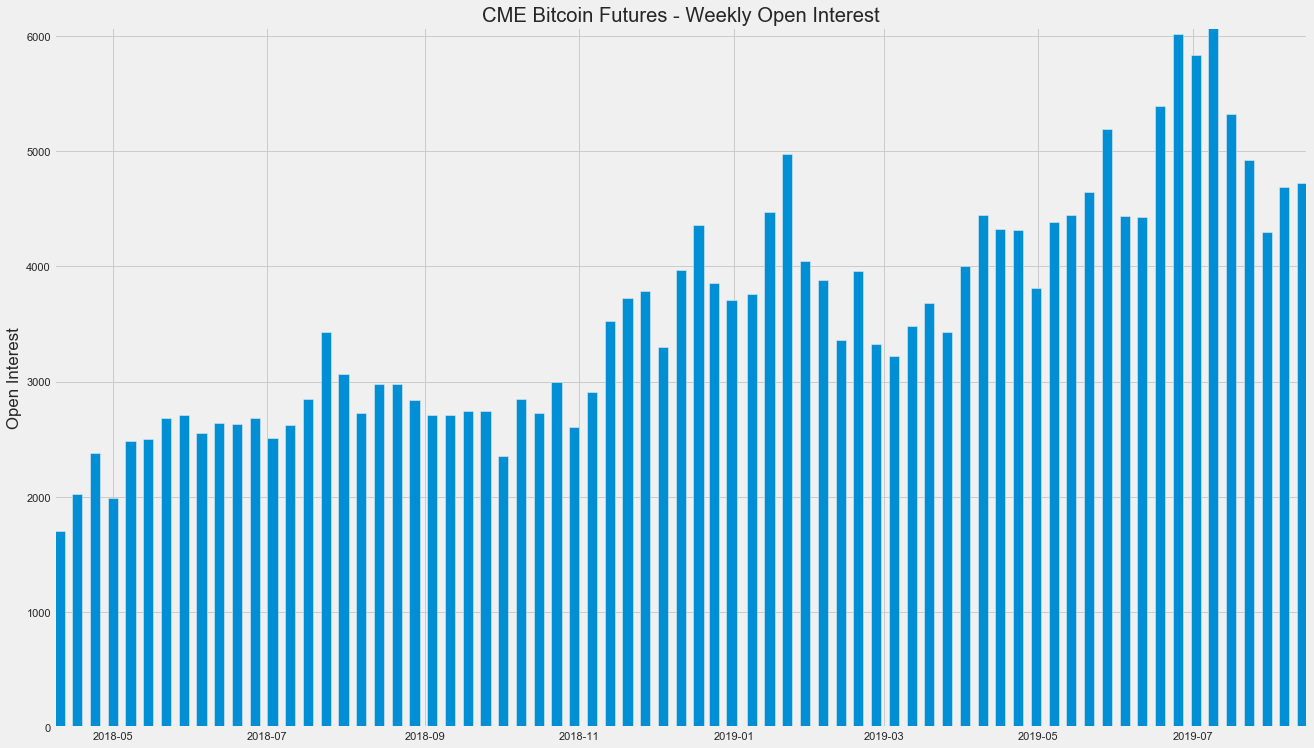

In [22]:
cftc.plot_open_interest(df=cftc.cot, width=20, height=12)

# Plot Reportable Positions

This plot shows all reportable positions by trader type. The dotted line indicates the current ratio of short-to-long positions.

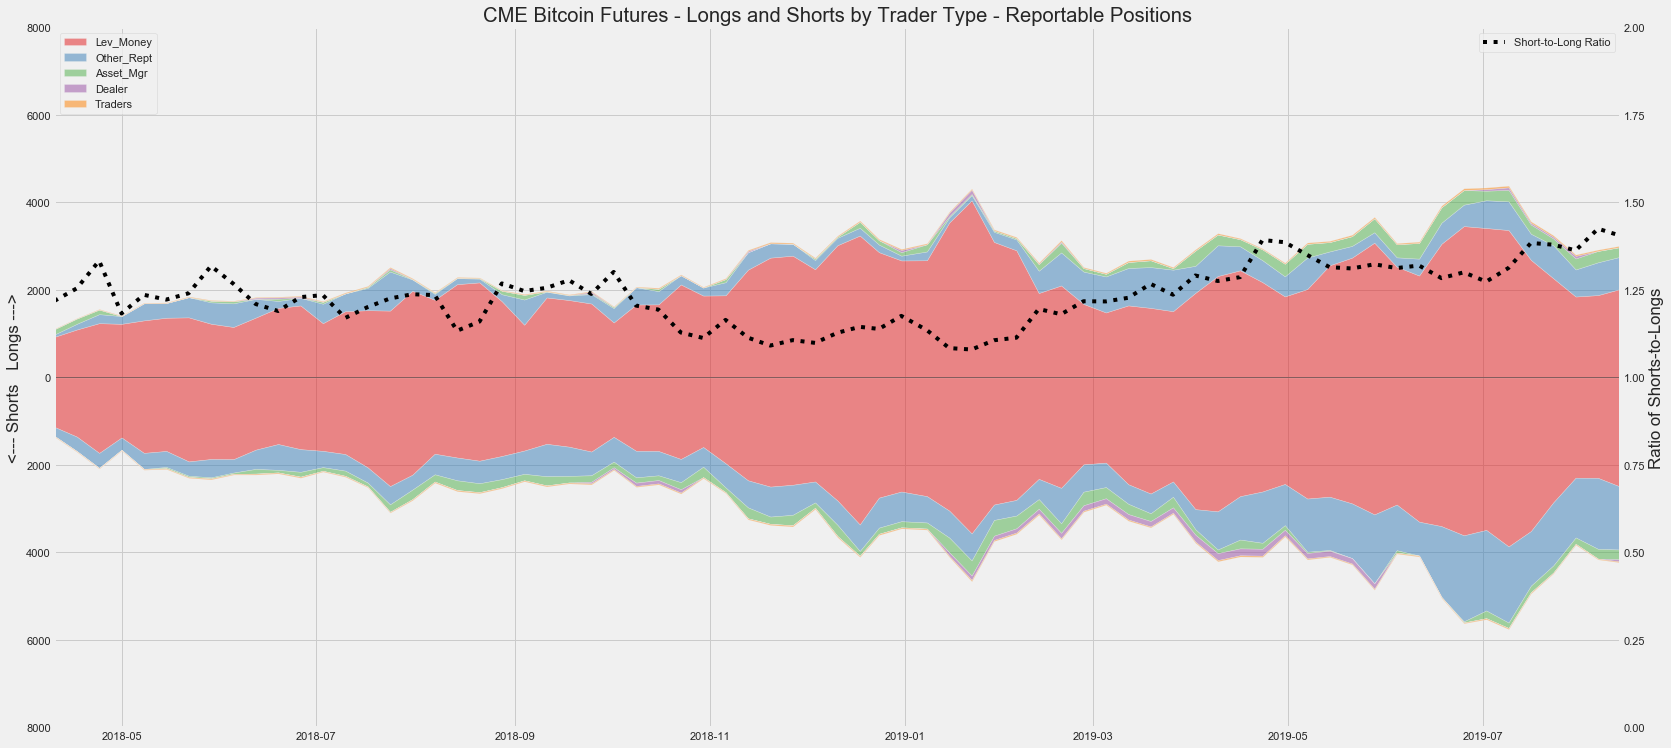

In [23]:
cftc.plot_reportable_positions(cftc.reportable_long, cftc.reportable_short, ratio_line=True)

# Plot All Positions

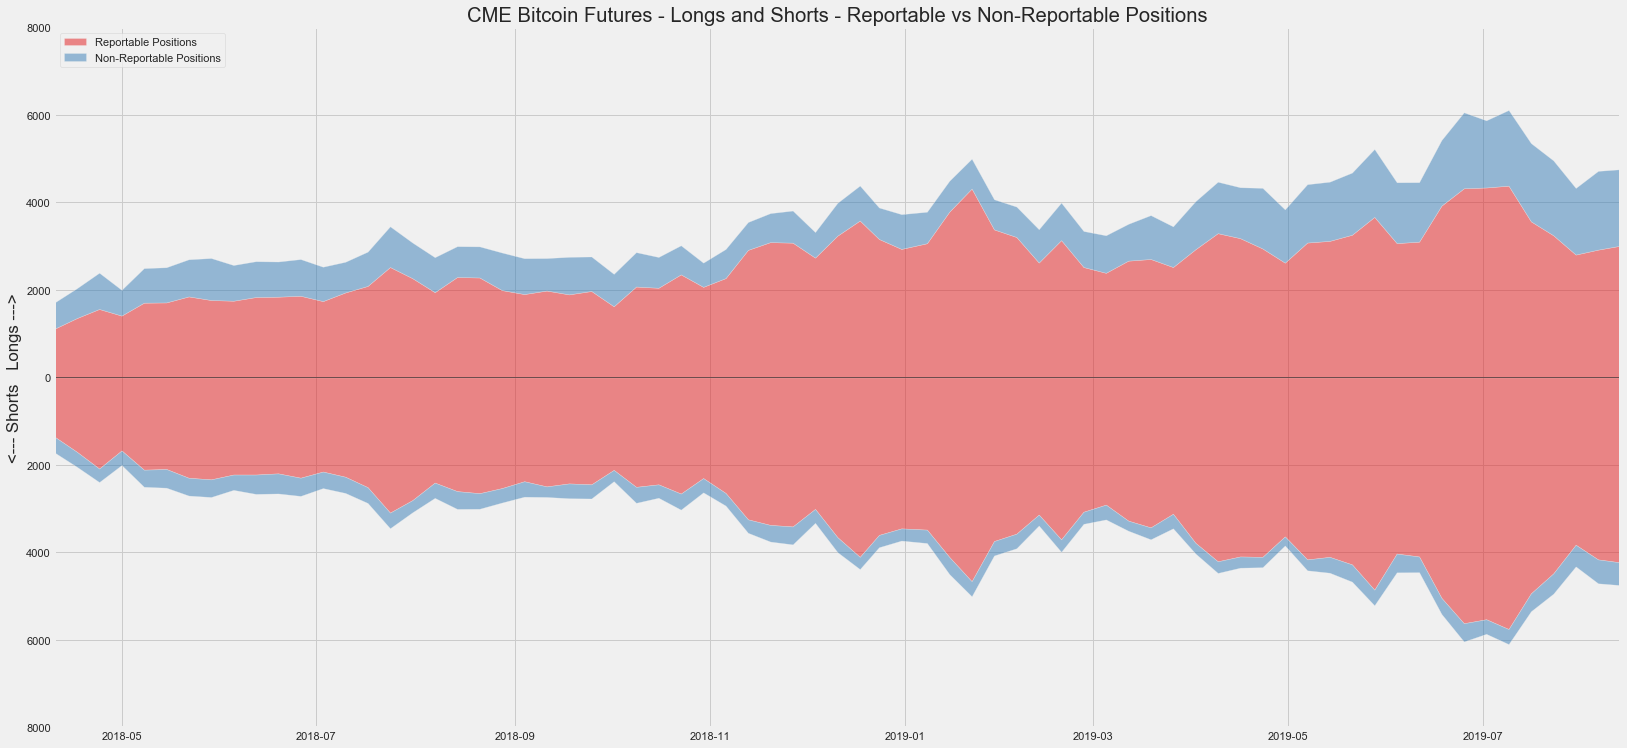

In [24]:
cftc.plot_longs_vs_shorts(cftc.all_longs, cftc.all_shorts)